# MonReader
---
## Summary

**Data Description:**

We collected page flipping video from smart phones and labelled them as flipping and not flipping.

We clipped the videos as short videos and labelled them as flipping or not flipping. The extracted frames are then saved to disk in a sequential order with the following naming structure: VideoID_FrameNumber

**Goal(s):**

Predict if the page is being flipped using a single image.

**Success Metrics:**

Evaluate model performance based on F1 score, the higher the better.

**Bonus(es):**

Predict if a given sequence of images contains an action of flipping.


# Setup

## Import Libraries

In [24]:
# Standards
import os
import re
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from scipy import stats
import statistics
import random
import tensorflow as tf

# For Data Import
from pathlib import Path
from collections import defaultdict

# For Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, precision_score, recall_score
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K

# For Prediction Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.data import Dataset

# For Vision Transformers

#  1
from PIL import Image
from torchvision import transforms
from transformers import ViTFeatureExtractor, ViTForImageClassification
import torch

#  2 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from vit_keras import vit
import tensorflow_hub as hub

#  3
import torch.nn as nn
import torch.optim as optim
from linformer import Linformer
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from vit_pytorch.efficient import ViT
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

import torchvision
from torchvision.transforms import ToTensor

from torch.utils.data import Dataset, DataLoader


# Warnings
import warnings

# Suppress deprecation warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=UserWarning)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("CUDA-enabled PyTorch: ", torch.cuda.is_available())  # Should print True if CUDA is set up correctly


Num GPUs Available:  1
CUDA-enabled PyTorch:  True


## Import Data

Image data should be preprocessed before feeding into a computer vision model. Here, we've included normalization and resizing of the data.

In [2]:
# Define the pre-processing functions
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

# Get image paths and labels for training and testing datasets
def get_image_paths_and_labels(directory):
    flip_image_paths = [str(path) for path in list(Path(directory + '/flip').glob('*.jpg'))]
    notflip_image_paths = [str(path) for path in list(Path(directory + '/notflip').glob('*.jpg'))]
    flip_labels = [1]*len(flip_image_paths)
    notflip_labels = [0]*len(notflip_image_paths)
    return flip_image_paths + notflip_image_paths, flip_labels + notflip_labels

# Folder paths
training_folder_path = r"C:\ref\images\training"
testing_folder_path = r"C:\ref\images\testing"


train_image_paths, train_image_labels = get_image_paths_and_labels(training_folder_path)
test_image_paths, test_image_labels = get_image_paths_and_labels(testing_folder_path)

batch_size = 32 # Define batch size

# Create Datasets
train_path_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_image_labels))
train_image_label_ds = train_path_ds.map(load_and_preprocess_from_path_label)
train_ds = train_image_label_ds.shuffle(buffer_size=len(train_image_labels)).batch(batch_size)

test_path_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_image_labels))
test_image_label_ds = test_path_ds.map(load_and_preprocess_from_path_label)
test_ds = test_image_label_ds.shuffle(buffer_size=len(test_image_labels)).batch(batch_size)


# Data Exploration

In [3]:
# Create functions that validate that the files are as expected.

def check_filenames(folder):
    """
    Check if all filenames in a folder follow the expected format: VideoID_FrameNumber.jpg
    """
    for root, _, files in os.walk(folder):
        for file in files:
            if not re.fullmatch(r'\d+_\d+\.jpg', file):
                print(f'Unexpected filename format: {os.path.join(root, file)}')


def count_files_in_folders(main_folder):
    """
    Count files in each subfolder within the main folder.
    """
    for folder_name in ['flip', 'notflip']:
        folder_path = os.path.join(main_folder, folder_name)
        
        if os.path.exists(folder_path):
            num_files = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            print(f"Number of files in '{folder_name}' subfolder: {num_files}")
        else:
            print(f"'{folder_path}' does not exist.")

# Check filenames in training and validation folders
print("Filename validation check:")
check_filenames(training_folder_path)
check_filenames(testing_folder_path)
print("-------------")

# Check the number of files in 'flip' and 'notflip' subfolders in training and validation folders
print("File count validation check:")
print(f"{training_folder_path}")
count_files_in_folders(training_folder_path)
print(f"{testing_folder_path}")
count_files_in_folders(testing_folder_path)
print("-------------")

Filename validation check:
-------------
File count validation check:
C:\ref\images\training
Number of files in 'flip' subfolder: 1162
Number of files in 'notflip' subfolder: 1230
C:\ref\images\testing
Number of files in 'flip' subfolder: 290
Number of files in 'notflip' subfolder: 307
-------------


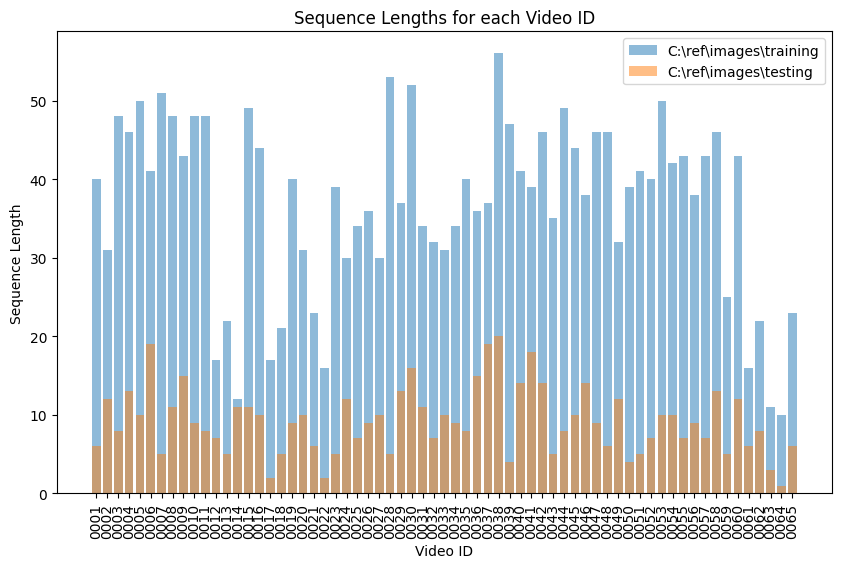

In [4]:
# Explore the length of the videos
# Sum sequence lengths for all video IDs in a given folder
def check_sequence_lengths(base_folder):
    """Check sequence lengths for all video IDs and return their sum."""
    # Create a dictionary to hold the number of frames for each video ID
    video_lengths = defaultdict(int)
    
    labels = ['flip', 'notflip']  # Define the labels
    for label in labels:  # Iterate over each label
        folder = os.path.join(base_folder, label)  # Form the complete path
        files = os.listdir(folder)
        
        # Count the number of frames for each video
        for file in files:
            video_id, _ = os.path.splitext(file)[0].split("_")
            video_lengths[video_id] += 1
            
    # Sum the lengths of all videos
    total_length = sum(video_lengths.values())
    
    return video_lengths, total_length

# Check the length of each video
def plot_sequence_lengths(folders):
    """Check sequence lengths for all video IDs in multiple folders and plot them."""
    plt.figure(figsize=(10, 6))
    
    for folder in folders:
        video_lengths, _ = check_sequence_lengths(folder)
        
        # Plot the sequence lengths for this folder
        plt.bar(video_lengths.keys(), video_lengths.values(), alpha=0.5, label=folder)

    plt.xlabel('Video ID')
    plt.ylabel('Sequence Length')
    plt.title('Sequence Lengths for each Video ID')
    plt.xticks(rotation=90)  # Rotate the x-axis labels for readability
    plt.legend()  # Add a legend to differentiate between folders
    plt.show()

plot_sequence_lengths([training_folder_path, testing_folder_path])

### Observations

- The sequence lengths vary from video to video. This means that not every video is the same length, and thus we are testing and training on variable amounts of information per video. This will need to be considered when predicting videos as a whole.
- In general, the video lengths in the testing set are shorter than in the training set. 

# Modelling

## Setup

In [5]:
# Define a CNN model

model_cnn = Sequential() # Base liner layer model
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))) # 1st layer
model_cnn.add(MaxPooling2D((2, 2))) # Reduce size of convolutional layer
model_cnn.add(Conv2D(64, (3, 3), activation='relu')) # 2nd layer
model_cnn.add(MaxPooling2D((2, 2))) # Reduce size of convolutional layer
model_cnn.add(Flatten()) # Convert to vector for dense layers
model_cnn.add(Dense(64, activation='relu')) # 3rd layer - dense
model_cnn.add(Dense(1, activation='sigmoid')) # Output Binary layer: flip or not flip


## Evaluation

In [6]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Setup Early Stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True) 

# compile the model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m, f1_m])

# fit the model
history_cnn = model_cnn.fit(train_ds, epochs=5, validation_data=test_ds, callbacks=[early_stop])

# evaluate the model
loss, accuracy, precision, recall, f1_score = model_cnn.evaluate(test_ds)


Epoch 1/5
75/75 [==============================] - 28s 94ms/step - loss: 0.7189 - accuracy: 0.6580 - precision_m: 0.6821 - recall_m: 0.5690 - f1_m: 0.5801 - val_loss: 0.4390 - val_accuracy: 0.7554 - val_precision_m: 0.9291 - val_recall_m: 0.5350 - val_f1_m: 0.6702
Epoch 2/5
75/75 [==============================] - 15s 90ms/step - loss: 0.2105 - accuracy: 0.9147 - precision_m: 0.9252 - recall_m: 0.9012 - f1_m: 0.9038 - val_loss: 0.1228 - val_accuracy: 0.9598 - val_precision_m: 0.9597 - val_recall_m: 0.9589 - val_f1_m: 0.9585
Epoch 3/5
75/75 [==============================] - 17s 99ms/step - loss: 0.0421 - accuracy: 0.9904 - precision_m: 0.9881 - recall_m: 0.9914 - f1_m: 0.9893 - val_loss: 0.0967 - val_accuracy: 0.9631 - val_precision_m: 0.9925 - val_recall_m: 0.9308 - val_f1_m: 0.9592
Epoch 4/5
75/75 [==============================] - 17s 92ms/step - loss: 0.0275 - accuracy: 0.9904 - precision_m: 0.9904 - recall_m: 0.9902 - f1_m: 0.9899 - val_loss: 0.0470 - val_accuracy: 0.9883 - val_pr

### Visualization

In this section, we showcase the performance of our trained model. Specifically, we:

1. Randomly select 5 images from our test set.
2. Predict whether each image represents a "flip" or "notflip" using the model.
3. Display each image alongside the model's prediction and the actual label.

This visualization serves as a quick and intuitive way to understand the model's accuracy and its potential areas of improvement.

1/1 [==============================] - 0s 461ms/step


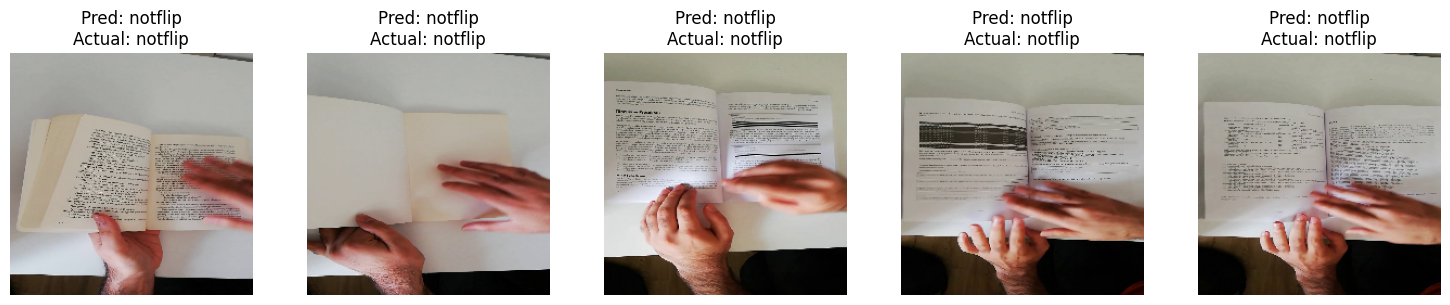

In [7]:
# Create lists from test_image_label_ds
test_images = []
test_labels = []

for image, label in test_image_label_ds:
    test_images.append(image.numpy())
    test_labels.append("flip" if label.numpy() == 1 else "notflip")

#Randomly select 5 images
indices = np.random.choice(len(test_images), 5, replace=False)
selected_images = [test_images[i] for i in indices]
selected_labels = [test_labels[i] for i in indices]

# Make predictions
predictions = model_cnn.predict(np.array(selected_images))

# Convert predictions to 'flip' or 'notflip' 
predicted_labels = ["flip" if pred > 0.5 else "notflip" for pred in predictions]

# Display the images with predictions
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    ax.imshow(selected_images[i])
    ax.set_title(f"Pred: {predicted_labels[i]}\nActual: {selected_labels[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [8]:
# Check labels for plotting in the next section
print(history_cnn.history.keys())

dict_keys(['loss', 'accuracy', 'precision_m', 'recall_m', 'f1_m', 'val_loss', 'val_accuracy', 'val_precision_m', 'val_recall_m', 'val_f1_m'])


### Metrics

We find that a general CNN prediction model scores highly for all metrics including accuracy, precision, recall, and F1 score.

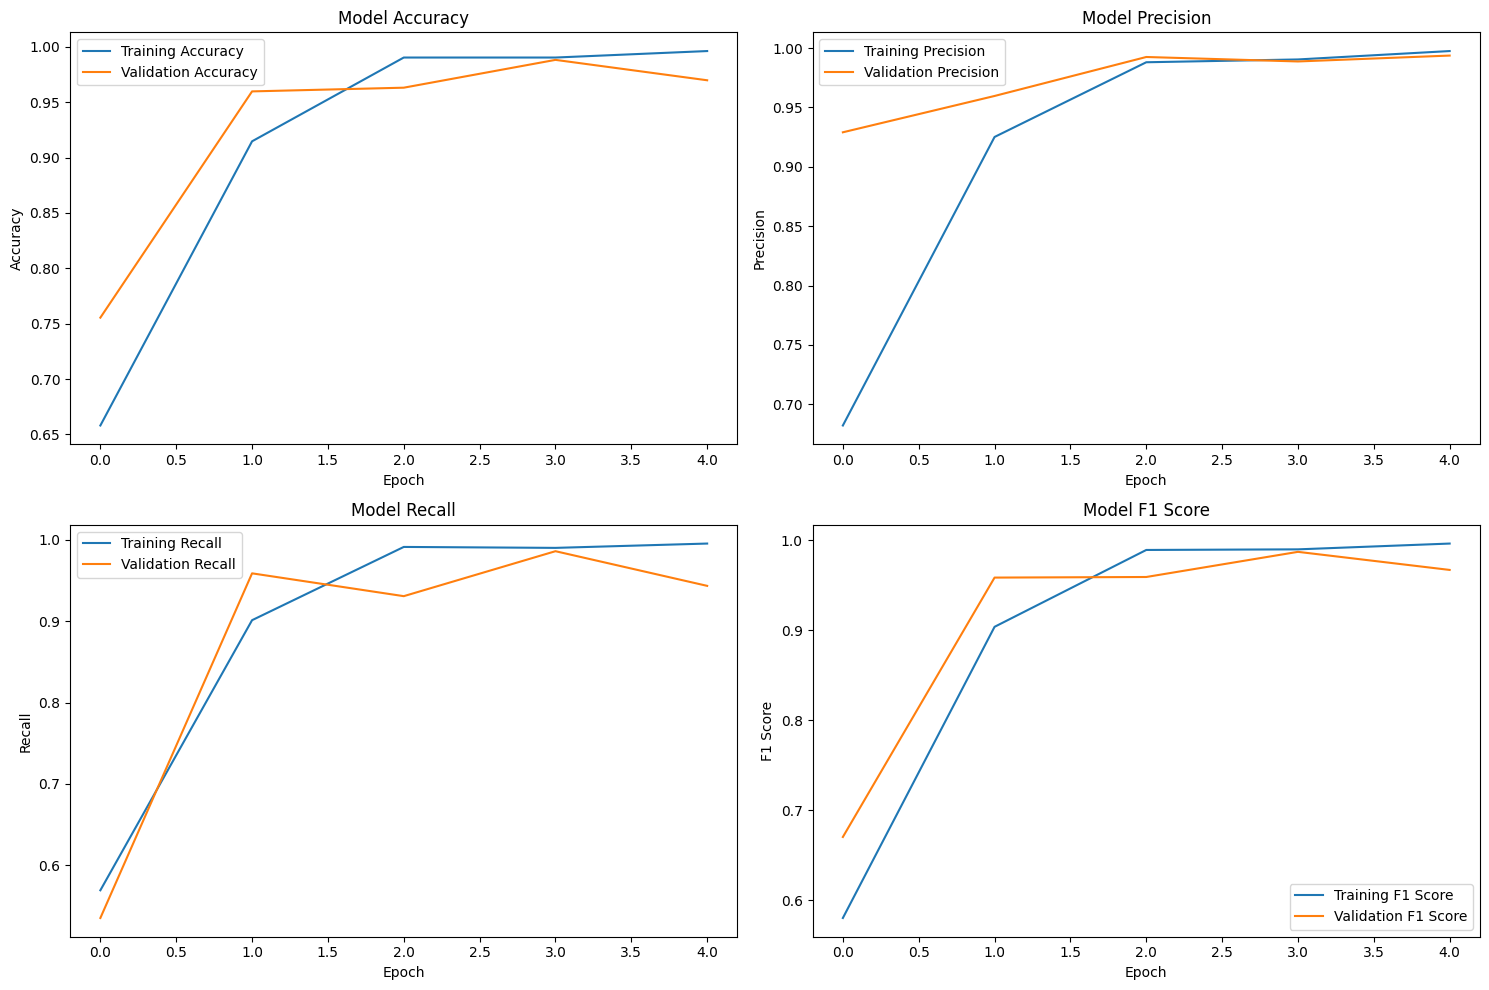

In [9]:
# Define the figure
plt.figure(figsize=(15,10))

# Define the subplot for accuracy
plt.subplot(2, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Define the subplot for precision
plt.subplot(2, 2, 2)
plt.plot(history_cnn.history['precision_m'], label='Training Precision')
plt.plot(history_cnn.history['val_precision_m'], label='Validation Precision')
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend()

# Define the subplot for recall
plt.subplot(2, 2, 3)
plt.plot(history_cnn.history['recall_m'], label='Training Recall')
plt.plot(history_cnn.history['val_recall_m'], label='Validation Recall')
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend()

# Define the subplot for f1 score
plt.subplot(2, 2, 4)
plt.plot(history_cnn.history['f1_m'], label='Training F1 Score')
plt.plot(history_cnn.history['val_f1_m'], label='Validation F1 Score')
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


## Bonus

Predict if a given sequence of images contains an action of flipping.

In [13]:
# Define the directory where the images are stored
image_dir = r"C:\ref\images\testing"

# Subdirectories ('flip' and 'notflip')
subdirs = ['flip', 'notflip']

# Dictionary to store predictions
predictions = {'flip': [], 'notflip': []}

# Iterate over each subdir
for subdir in subdirs:
    subdir_path = os.path.join(image_dir, subdir)
    
    # Iterate over images in directory
    for file in os.listdir(subdir_path):
        # Load the image file
        img = image.load_img(os.path.join(subdir_path, file), target_size=(224, 224))
        
        # Convert the image to a numpy array and normalize
        img_tensor = image.img_to_array(img)  # shape is (224, 224, 3)
        img_tensor = np.expand_dims(img_tensor, axis=0)  # shape is (1, 224, 224, 3)
        img_tensor /= 255.  # model was trained on inputs normalized to [0,1]

        # Pass the image through the model and get the prediction
        prediction = model_cnn.predict(img_tensor)
        
        # Store prediction
        predictions[subdir].append(prediction)


1/1 [==============================] - 0s 26ms/step


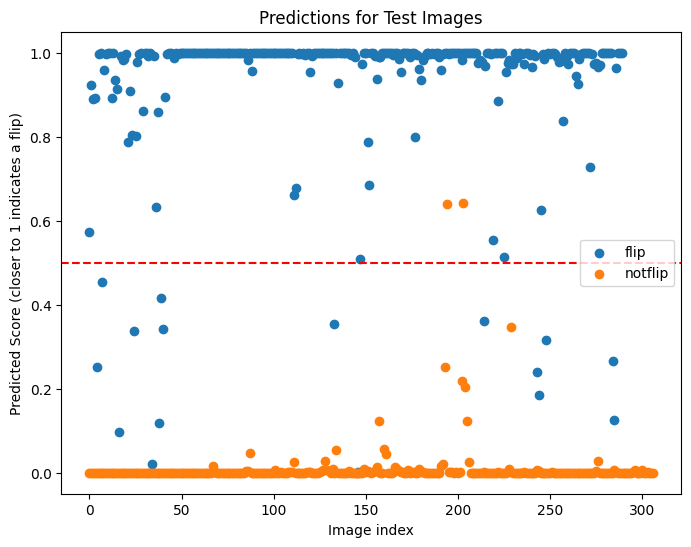

In [14]:
# Create a new figure
plt.figure(figsize=(8, 6))

# Plot the predictions for each subdirectory
for subdir, subdir_predictions in predictions.items():
    plt.scatter(range(len(subdir_predictions)), [pred[0][0] for pred in subdir_predictions], label=subdir)

# Add a horizontal line at 0.5 (our decision boundary)
plt.axhline(y=0.5, color='r', linestyle='--')

# Add labels and a legend
plt.title('Predictions for Test Images')
plt.xlabel('Image index')
plt.ylabel('Predicted Score (closer to 1 indicates a flip)')
plt.legend()

# Show the plot
plt.show()

# Summary

Above, the 'notflip' points (indicated by orange dots) should be closer to zero, indicating a 'notflip'. The same is true in opposite for the 'flip' and blue dots.

This indicates visually, in addition to the numerical metrics above, that the model is fairly capable of identifying a flip given a series of images.

# Vision Transformers

Multiple experimental attempts below.

## ViT Pytorch

### Setup

In [20]:
# Setup data
class CustomDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.classes = ["flip", "notflip"]
        self.imgs_path = [os.path.join(main_dir, cls, img) for cls in self.classes for img in os.listdir(os.path.join(main_dir, cls))]
        self.labels = [self.classes.index(cls) for cls in self.classes for img in os.listdir(os.path.join(main_dir, cls))]

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
        img_path = self.imgs_path[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label
    

# Data transformation/augmentation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load datasets
train_dataset = CustomDataset(training_folder_path, transform=transform)
test_dataset = CustomDataset(testing_folder_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [15]:
# define some constants
batch_size = 64 
epochs = 10
lr = 3e-5
gamma = 0.7
seed = 142
IMG_SIZE = 128
patch_size = 16
num_classes = 2

# Training device:
device = 'cuda'

# Linear Transformer:
efficient_transformer = Linformer(dim=128, seq_len=64+1, depth=12, heads=8, k=64)

# Vision Transformer Model: 
model_py = ViT(dim=128, image_size=128, patch_size=patch_size, num_classes=num_classes, transformer=efficient_transformer, channels=3).to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model_py.parameters(), lr=lr)

# Learning Rate Scheduler for Optimizer:
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)


### Compile and Train

In [21]:
# Compile isn't exactly accurate with Pytorch, but the here's the equivalent
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_py.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [25]:
# Track metrics over epochs
train_losses = []
test_losses = []
test_accuracies = []
test_precisions = []
test_recalls = []

num_epochs = 10

for epoch in range(num_epochs):
    model_py.train()
    train_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model_py(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Calculate average train loss for the epoch
    train_loss = train_loss / len(train_loader)
    train_losses.append(train_loss)

    # Evaluate the model and calculate metrics
    model_py.eval()
    test_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_py(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate average test loss, accuracy, precision, and recall
    test_loss = test_loss / len(test_loader)
    accuracy = 100 * sum(np.array(all_predictions) == np.array(all_labels)) / len(all_labels)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)

    # Store metrics for plotting
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    test_precisions.append(precision)
    test_recalls.append(recall)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

Epoch [1/10] | Train Loss: 0.1204 | Test Loss: 0.1157 | Test Accuracy: 95.98%
Epoch [2/10] | Train Loss: 0.0710 | Test Loss: 0.1025 | Test Accuracy: 96.48%
Epoch [3/10] | Train Loss: 0.0830 | Test Loss: 0.1020 | Test Accuracy: 96.31%
Epoch [4/10] | Train Loss: 0.0797 | Test Loss: 0.0884 | Test Accuracy: 97.49%
Epoch [5/10] | Train Loss: 0.0903 | Test Loss: 0.1613 | Test Accuracy: 94.14%
Epoch [6/10] | Train Loss: 0.1144 | Test Loss: 0.0871 | Test Accuracy: 96.98%
Epoch [7/10] | Train Loss: 0.0520 | Test Loss: 0.0901 | Test Accuracy: 97.15%
Epoch [8/10] | Train Loss: 0.0450 | Test Loss: 0.1269 | Test Accuracy: 96.48%
Epoch [9/10] | Train Loss: 0.0340 | Test Loss: 0.0791 | Test Accuracy: 98.32%
Epoch [10/10] | Train Loss: 0.0610 | Test Loss: 0.1232 | Test Accuracy: 97.15%


### Evaluate

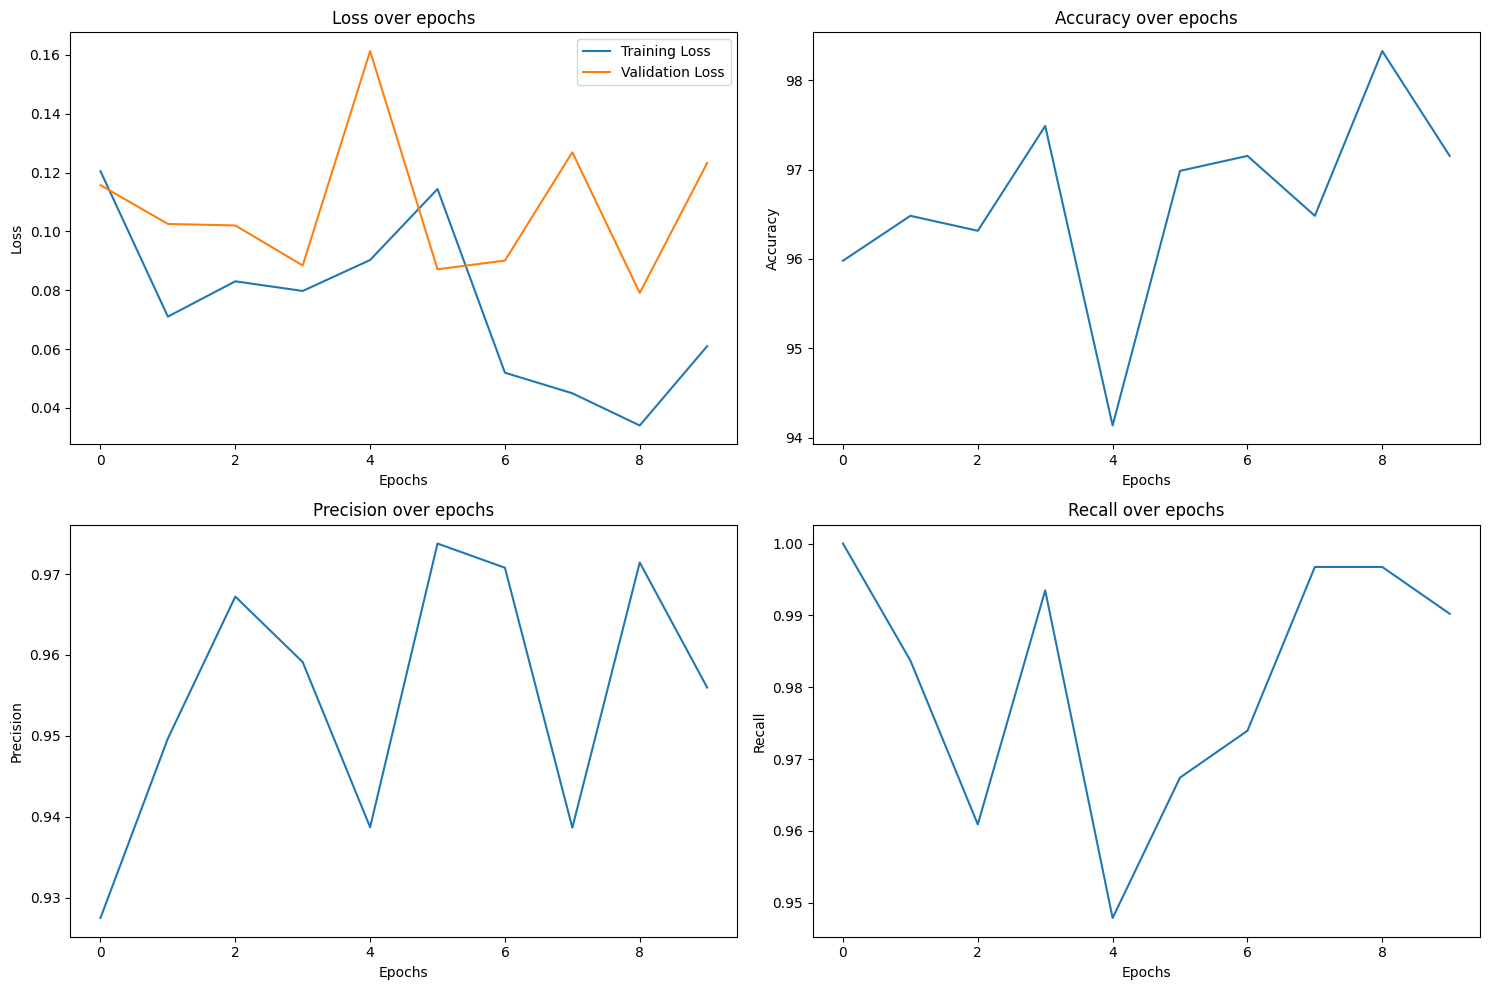

In [26]:
# Plotting
plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(2, 2, 2)
plt.plot(test_accuracies)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Precision
plt.subplot(2, 2, 3)
plt.plot(test_precisions)
plt.title('Model Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')

# Recall
plt.subplot(2, 2, 4)
plt.plot(test_recalls)
plt.title('Model Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')

plt.tight_layout()
plt.show()

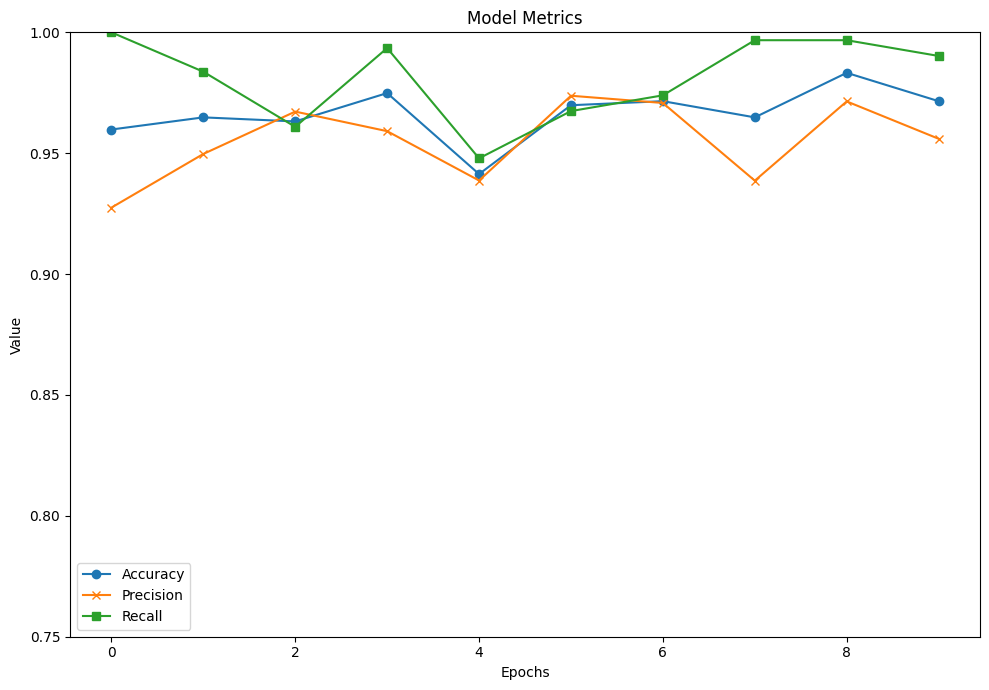

In [32]:
scaled_test_accuracies = [accuracy/100 for accuracy in test_accuracies]

# Plotting
plt.figure(figsize=(10, 7))

# Overlay Accuracy, Precision, and Recall on a single plot
plt.plot(scaled_test_accuracies, label='Accuracy', marker='o')
plt.plot(test_precisions, label='Precision', marker='x')
plt.plot(test_recalls, label='Recall', marker='s')
plt.title('Model Metrics')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.ylim(0.75, 1)
plt.legend()

plt.tight_layout()
plt.show()


# ViT Experimentation

Here, we try alternative Transformers to see how they behave with the dataset. Overall, they did not perform as well as the PyTorch Transformer, and so they are gathered separately into this section.

## ViT_b16

### Setup

Vision Transformer (ViT) Selection: The vit_b16 model is chosen. This refers to a Vision Transformer model that uses patches of size 16x16.

After the base Vision Transformer model:

- The output is flattened to 1D.
- A dense layer is added for binary classification, with a 'sigmoid' activation function.

In [27]:
# define some constants
batch_size_vit = 32 # controls how many samples will be passed through at once. Used for memory limitations.
img_size_vit = (224, 224) # image resizing target

# Prepare train data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory=training_folder_path,
    target_size=img_size_vit,
    color_mode="rgb",
    batch_size=batch_size_vit,
    class_mode="binary",
    shuffle=True,
)

# Prepare test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=testing_folder_path,
    target_size=img_size_vit,
    color_mode="rgb",
    batch_size=batch_size_vit,
    class_mode="binary",
    shuffle=False,
)

# Define the image size and patch size
image_size = 224
patch_size = 16

# Define model layer-by-layer
# Load the base model
base_model = vit.vit_b16(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
)

# Add the classification layer
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(), # reshape to 1d
    tf.keras.layers.Dense(1, activation='sigmoid'), # Final binary classification layer
])


Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


### Compile and Train

In [42]:
# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


In [43]:
# Train
epochs = 10
history = model.fit(train_generator, 
                    epochs=epochs, 
                    validation_data=test_generator)


Epoch 1/10
75/75 [==============================] - 2496s 33s/step - loss: 0.8860 - accuracy: 0.4967 - precision_35: 0.5089 - recall_35: 0.6073 - val_loss: 0.6943 - val_accuracy: 0.5142 - val_precision_35: 0.5142 - val_recall_35: 1.0000
Epoch 2/10
75/75 [==============================] - 2352s 31s/step - loss: 0.6983 - accuracy: 0.5004 - precision_35: 0.5128 - recall_35: 0.5699 - val_loss: 0.6869 - val_accuracy: 0.5142 - val_precision_35: 0.5142 - val_recall_35: 1.0000
Epoch 3/10
75/75 [==============================] - 2257s 30s/step - loss: 0.6913 - accuracy: 0.5334 - precision_35: 0.5397 - recall_35: 0.6293 - val_loss: 0.6713 - val_accuracy: 0.5729 - val_precision_35: 0.9062 - val_recall_35: 0.1889
Epoch 4/10
75/75 [==============================] - 34886s 471s/step - loss: 0.7154 - accuracy: 0.5167 - precision_35: 0.5296 - recall_35: 0.5382 - val_loss: 0.7038 - val_accuracy: 0.5142 - val_precision_35: 0.5142 - val_recall_35: 1.0000
Epoch 5/10
75/75 [==============================] 

### Evaluate

In [45]:
# Evaluate
loss, accuracy, precision, recall = model.evaluate(test_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

19/19 [==============================] - 198s 10s/step - loss: 0.6092 - accuracy: 0.6449 - precision_35: 0.6039 - recall_35: 0.8990
Loss: 0.6092495322227478, Accuracy: 0.6448911428451538, Precision: 0.6039387583732605, Recall: 0.8990228176116943


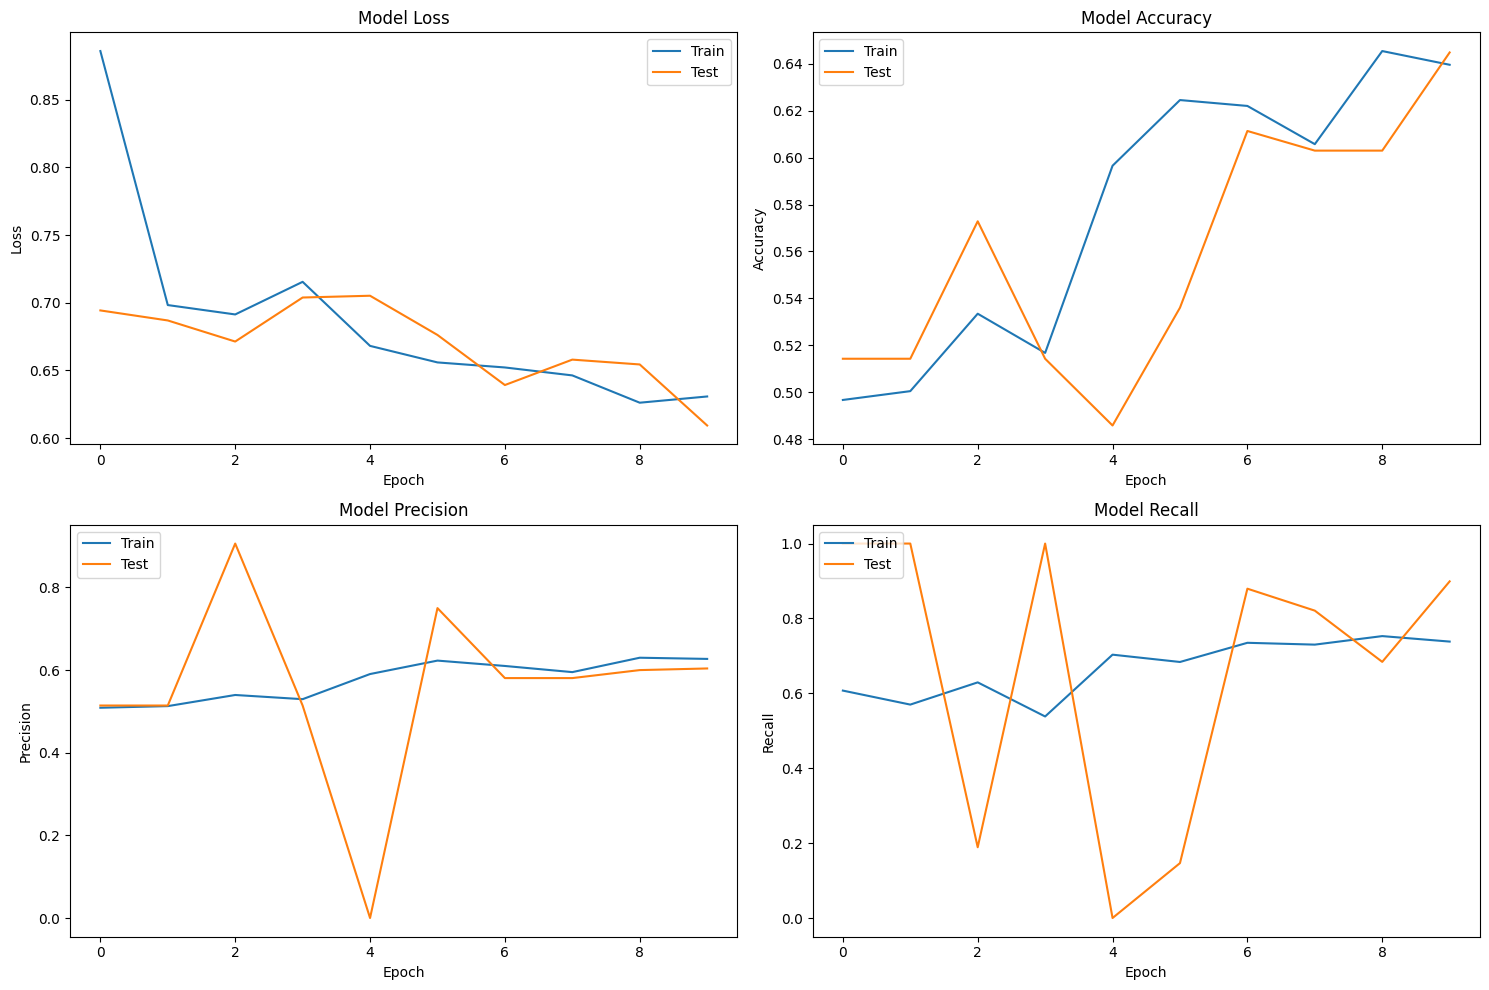

In [55]:
plt.figure(figsize=(15, 10))

# Plot training & validation loss values
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation precision values
plt.subplot(2, 2, 3)
plt.plot(history.history['precision_35'])
plt.plot(history.history['val_precision_35'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation recall values
plt.subplot(2, 2, 4)
plt.plot(history.history['recall_35'])
plt.plot(history.history['val_recall_35'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


## Optimization - Attempt 1

1. Regularization:
    - Dropout: I will add a Dropout layer after the Flatten layer.
    - Weight Decay (L2 Regularization): I will introduce L2 regularization to the Dense layer.
2. Cadence
    - Early Stopping: This will stop the training if it doesn't see improvement.
    - Model Checkpoints: This will save the best weights of the model based on the validation loss.
3. Learning Rate
    - Scheduler. This will reduce the LR if the loss doesn't improve.

### Setup

In [71]:
# Define the image size and patch size
image_size = 224
patch_size = 16

# Define model layer-by-layer
base_model_2 = vit.vit_b16(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=False,
    pretrained_top=False,
)

# Add regularization to the model
model_2 = tf.keras.Sequential([
    base_model_2,
    tf.keras.layers.Flatten(), # reshape to 1d
    tf.keras.layers.Dropout(0.5), # Dropout layer added for regularization
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)), # L2 regularization added
])

c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


### Compile and Train

In [72]:
# Compile
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [74]:
# Early stopping to stop training if validation loss does not improve for 5 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Model checkpoint to save the best model based on validation loss
checkpoint_path = "best_model_2.h5"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# Reduce learning rate if validation loss does not improve for 3 consecutive epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

epochs = 5

# Train the model
history_2 = model_2.fit(train_generator, 
                         epochs=epochs, 
                         validation_data=test_generator,
                         callbacks=callbacks)

Epoch 1/5
75/75 [==============================] - ETA: 0s - loss: 0.7312 - accuracy: 0.4929 - precision_70: 0.5063 - recall_70: 0.5528 
Epoch 1: val_loss improved from inf to 0.70309, saving model to best_model_2.h5
75/75 [==============================] - 2918s 39s/step - loss: 0.7312 - accuracy: 0.4929 - precision_70: 0.5063 - recall_70: 0.5528 - val_loss: 0.7031 - val_accuracy: 0.5142 - val_precision_70: 0.5142 - val_recall_70: 1.0000 - lr: 0.0010
Epoch 2/5
75/75 [==============================] - ETA: 0s - loss: 0.7128 - accuracy: 0.5259 - precision_70: 0.5363 - recall_70: 0.5764 
Epoch 2: val_loss improved from 0.70309 to 0.69703, saving model to best_model_2.h5
75/75 [==============================] - 2777s 37s/step - loss: 0.7128 - accuracy: 0.5259 - precision_70: 0.5363 - recall_70: 0.5764 - val_loss: 0.6970 - val_accuracy: 0.5142 - val_precision_70: 0.5142 - val_recall_70: 1.0000 - lr: 0.0010
Epoch 3/5
75/75 [==============================] - ETA: 0s - loss: 0.6917 - accuracy

### Evaluate

In [ ]:
# Evaluate
loss, accuracy, precision, recall = model_2.evaluate(test_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

In [ ]:
# Check labels for plotting in the next section
print(history_2.history.keys())

In [ ]:
plt.figure(figsize=(15, 10))

# Plot training & validation loss values
plt.subplot(2, 2, 1)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(2, 2, 2)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation precision values
plt.subplot(2, 2, 3)
plt.plot(history_2.history['precision_35'])
plt.plot(history_2.history['val_precision_35'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation recall values
plt.subplot(2, 2, 4)
plt.plot(history_2.history['recall_35'])
plt.plot(history_2.history['val_recall_35'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


## Optimization - Attempt 2

### Setup

In [47]:
# Define constants
batch_size_ENL = 32
img_size_ENL = 224  # default input size

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    directory=training_folder_path,
    target_size=(img_size_ENL, img_size_ENL),
    color_mode="rgb",
    batch_size=batch_size_ENL,
    class_mode="binary",
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=testing_folder_path,
    target_size=(img_size_ENL, img_size_ENL),
    color_mode="rgb",
    batch_size=batch_size_ENL,
    class_mode="binary",
    shuffle=False
)

# Load the EfficientNet-Lite model 
model_url = "https://tfhub.dev/tensorflow/efficientnet/lite0/feature-vector/2"
#base_model_ENL = hub.KerasLayer(model_url, input_shape=(img_size_ENL, img_size_ENL, 3), trainable=True)

# Use a lambda layer to wrap the hub.KerasLayer
# (Wasn't compatible otherwise)
base_model_ENL = tf.keras.layers.Lambda(
    lambda x: hub.KerasLayer(model_url, trainable=True)(x)
)

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


### Compile and Train

In [49]:
# Construct the model
model_ENL = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_size_ENL, img_size_ENL, 3)),
    base_model,
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile
model_ENL.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy', 'Precision', 'Recall'])

In [50]:
# Train
history_ENL = model_ENL.fit(train_generator, epochs=5, validation_data=test_generator)

Epoch 1/5
75/75 [==============================] - 2401s 32s/step - loss: 0.7914 - accuracy: 0.5159 - precision: 0.5270 - recall: 0.5715 - val_loss: 0.7043 - val_accuracy: 0.5142 - val_precision: 0.5142 - val_recall: 1.0000
Epoch 2/5
75/75 [==============================] - 2274s 30s/step - loss: 0.7056 - accuracy: 0.5100 - precision: 0.5216 - recall: 0.5699 - val_loss: 0.7566 - val_accuracy: 0.5142 - val_precision: 0.5142 - val_recall: 1.0000
Epoch 3/5
75/75 [==============================] - 2367s 32s/step - loss: 0.7113 - accuracy: 0.5084 - precision: 0.5197 - recall: 0.5789 - val_loss: 0.6953 - val_accuracy: 0.4858 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
75/75 [==============================] - 2350s 31s/step - loss: 0.7000 - accuracy: 0.5042 - precision: 0.5155 - recall: 0.5959 - val_loss: 0.6972 - val_accuracy: 0.4858 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
75/75 [==============================] - 2162s 29s/step - loss: 0.6882 - accur

### Evaluate

In [51]:
# Evaluate
loss, accuracy, precision, recall = model_ENL.evaluate(test_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")

19/19 [==============================] - 161s 8s/step - loss: 0.6896 - accuracy: 0.5427 - precision: 0.5599 - recall: 0.5179
Loss: 0.6895703673362732, Accuracy: 0.5427135825157166, Precision: 0.5598591566085815, Recall: 0.5179153084754944


In [54]:
# Check labels for plotting in the next section
print(history_ENL.history.keys())

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


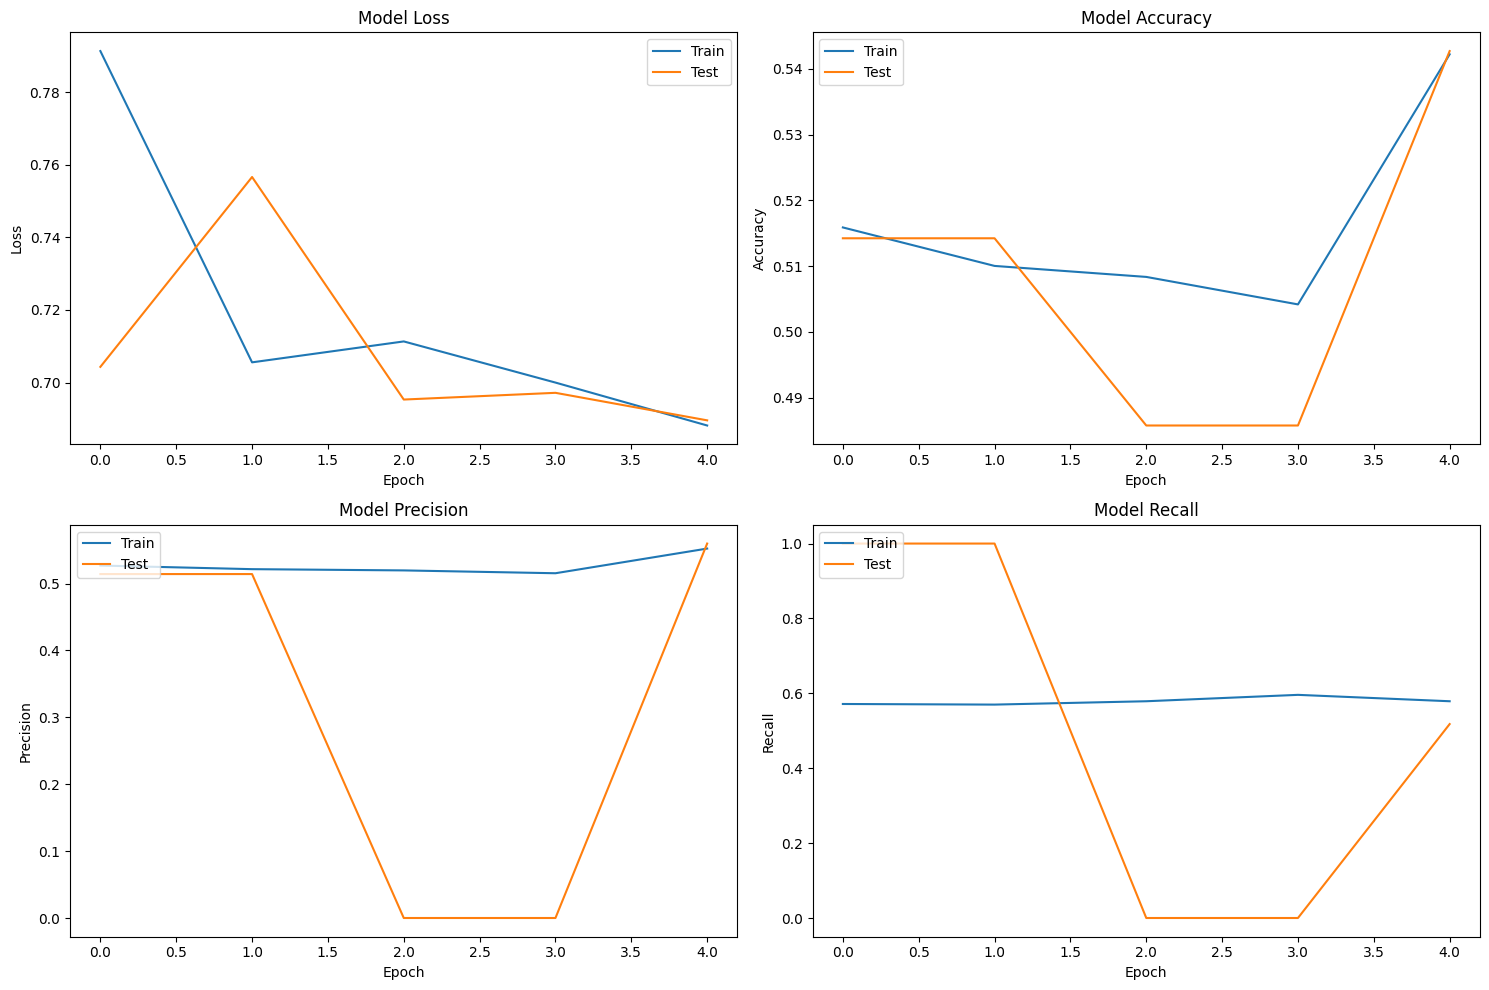

In [55]:
plt.figure(figsize=(15, 10))

# Plot training & validation loss values
plt.subplot(2, 2, 1)
plt.plot(history_ENL.history['loss'])
plt.plot(history_ENL.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(2, 2, 2)
plt.plot(history_ENL.history['accuracy'])
plt.plot(history_ENL.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation precision values
plt.subplot(2, 2, 3)
plt.plot(history_ENL.history['precision'])
plt.plot(history_ENL.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation recall values
plt.subplot(2, 2, 4)
plt.plot(history_ENL.history['recall'])
plt.plot(history_ENL.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


## Summary

# Appendix: Time-Dependant Prediction

Here, we will address predicting a flip from a given complete video. 

This task is more complex than image classification for a couple of reasons. First, the model now has to understand the time-relationship between images in a sequence. Second, the model also has to be able to understand the concept of the "flipping" action, which involves more than just the static content of a single image.

For these reasons, we will look at using a Long Short-Term Memory (LSTM) network to analyze the sequence of images and predict if a page flip action is occurring. 

## Prepare Data

Here we prepare functions that will get and preprocess the images when called. 

All frames from a single video were grouped together in a dictionary where the key was the video ID and the value was a list of frames. Each frame was resized to 224x224 and normalized to a range [0,1]. The frames were sorted according to their sequence in the video.

In [47]:
# Similar to previous function

# Define the pre-processing functions and get images
def load_and_sort_frames(flip_folder, notflip_folder):
    # Load all images
    all_images = {}
    labels = {}
    for folder in [flip_folder, notflip_folder]:
        label = 1 if folder == flip_folder else 0  # Assign label based on folder
        for filename in os.listdir(folder):
            # The filename format is VideoID_FrameNumber.jpg
            videoid, frameno_with_ext = filename.split('_')
            frameno, ext = frameno_with_ext.split('.')
            frameno = int(frameno)
            img = cv2.imread(os.path.join(folder, filename))
            img = cv2.resize(img, (224, 224))
            img = img / 255.0
            if videoid not in all_images:
                all_images[videoid] = []
                labels[videoid] = label  # Assign label to this video
            all_images[videoid].append((frameno, img))
    
    # Sort frames for each video
    for videoid in all_images:
        all_images[videoid].sort(key=lambda x: x[0])  # Sort by frame number
        all_images[videoid] = [x[1] for x in all_images[videoid]]  # Remove frame number

    return all_images, labels


## Model

### Define Model

For each bucket, a separate model was trained. The model consisted of a Convolutional Neural Network (CNN) followed by a Long Short-Term Memory (LSTM) network. The CNN extracted spatial features from each frame, while the LSTM captured temporal dependencies between the frames. The output of the LSTM was passed to a Dense layer for binary classification. Each model was trained only on the sequences within its corresponding bucket. After training, the models were saved to disk.

In [48]:
def train_model(bucketed_data):
    models = {}
    for bucket_size in bucketed_data:
        print(f"Training on bucket {bucket_size}:")
        
        bucket_data = bucketed_data[bucket_size]
        
        # Define the model for this bucket
        model = Sequential()
        model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(bucket_size, 224, 224, 3)))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu')))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))
        model.add(LSTM(32))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy', Precision(), Recall()])

        for data in bucket_data:
            x, y = data
            x = np.expand_dims(x, axis=0)  # Add an extra dimension
            y = np.array([y])  # Convert y to numpy array
            model.fit(x, y, epochs=5, batch_size=32)

        # Save the model after training
        model_path = f"model_{bucket_size}.h5"
        model.save(model_path)
        models[bucket_size] = model_path

    return models

### Train Model

In [49]:
# Load, bucket, and pad videos
flip_folder = r"C:\ref\images\training\flip"
notflip_folder = r"C:\ref\images\training\notflip"
all_images, labels = load_and_sort_frames(flip_folder, notflip_folder)

bucket_sizes = [10, 20, 30, 40, 50, 60]
bucketed_data = {}
for size in bucket_sizes:
    bucketed_data[size] = []

for videoid in all_images:
    video_frames = all_images[videoid]
    bucket_size = min(max(bucket_sizes), len(video_frames), key=lambda x:abs(x-len(video_frames)))
    
    # Add an extra dimension to video_frames and pad
    video_frames = [video_frames]  # Add extra dimension
    padded_frames = pad_sequences(video_frames, maxlen=bucket_size, dtype='float32')
    
    # Remove the extra dimension from padded_frames
    padded_frames = padded_frames[0]  # Remove extra dimension

    # Assuming you have your labels in a dictionary with video ID as key
    label = labels[videoid]

    if bucket_size not in bucketed_data:
        bucketed_data[bucket_size] = []
    bucketed_data[bucket_size].append((padded_frames, label))

models = train_model(bucketed_data)


Training on bucket 10:
Epoch 1/5
1/1 [==============================] - 5s 5s/step - loss: 0.6440 - accuracy: 1.0000 - precision_36: 1.0000 - recall_36: 1.0000
Epoch 2/5
1/1 [==============================] - 1s 1s/step - loss: 0.2155 - accuracy: 1.0000 - precision_36: 1.0000 - recall_36: 1.0000
Epoch 3/5
1/1 [==============================] - 1s 1s/step - loss: 0.2000 - accuracy: 1.0000 - precision_36: 1.0000 - recall_36: 1.0000
Epoch 4/5
1/1 [==============================] - 1s 1s/step - loss: 0.1847 - accuracy: 1.0000 - precision_36: 1.0000 - recall_36: 1.0000
Epoch 5/5
1/1 [==============================] - 1s 1s/step - loss: 0.1701 - accuracy: 1.0000 - precision_36: 1.0000 - recall_36: 1.0000


c:\Users\danie\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training on bucket 20:
Training on bucket 30:
Epoch 1/5
1/1 [==============================] - 6s 6s/step - loss: 0.6157 - accuracy: 1.0000 - precision_38: 1.0000 - recall_38: 1.0000
Epoch 2/5
1/1 [==============================] - 4s 4s/step - loss: 0.1779 - accuracy: 1.0000 - precision_38: 1.0000 - recall_38: 1.0000
Epoch 3/5
1/1 [==============================] - 4s 4s/step - loss: 0.1658 - accuracy: 1.0000 - precision_38: 1.0000 - recall_38: 1.0000
Epoch 4/5
1/1 [==============================] - 4s 4s/step - loss: 0.1550 - accuracy: 1.0000 - precision_38: 1.0000 - recall_38: 1.0000
Epoch 5/5
1/1 [==============================] - 3s 3s/step - loss: 0.1453 - accuracy: 1.0000 - precision_38: 1.0000 - recall_38: 1.0000
Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 0.1362 - accuracy: 1.0000 - precision_38: 1.0000 - recall_38: 1.0000
Epoch 2/5
1/1 [==============================] - 3s 3s/step - loss: 0.1275 - accuracy: 1.0000 - precision_38: 1.0000 - recall_38: 1.

### Test Model

For testing, we employed a similar bucketing strategy as we did for training, with different bucket sizes to match the length of the sequences in the test set. Each sequence was evaluated by the model that was trained on the bucket with the closest sequence length. The performance was evaluated in terms of loss, accuracy, precision, and recall.

In [50]:
# Load and preprocess the testing data
test_flip_folder = r"C:\ref\images\testing\flip"
test_notflip_folder = r"C:\ref\images\testing\notflip"
test_images, test_labels = load_and_sort_frames(test_flip_folder, test_notflip_folder)

print(f"test_images size: {len(test_images)}")
print(f"test_labels size: {len(test_labels)}")

# Define bucket sizes for the test set
test_bucket_sizes = [5, 10, 15, 20]

# Bucket and pad videos in the testing data
bucketed_test_data = {}
for size in test_bucket_sizes:
    bucketed_test_data[size] = []

for videoid in test_images:
    video_frames = test_images[videoid]
    bucket_size = min(test_bucket_sizes, key=lambda x:abs(x-len(video_frames)))

    # Add an extra dimension to video_frames and pad
    video_frames = [video_frames]  # Add extra dimension
    padded_frames = pad_sequences(video_frames, maxlen=bucket_size, dtype='float32')
    
    # Remove the extra dimension from padded_frames
    padded_frames = padded_frames[0]  # Remove extra dimension

    # Get the label for this video
    label = test_labels[videoid]

    bucketed_test_data[bucket_size].append((padded_frames, label))


test_images size: 65
test_labels size: 65


In [51]:
# For each bucket size
for bucket_size in bucketed_test_data:
    print(f"Evaluating on bucket {bucket_size}:")
    
    # Get the data for this bucket size
    bucket_data = bucketed_test_data[bucket_size]
    
    # Check if we have a model for this bucket size
    if bucket_size not in models:
        print(f"No model trained for bucket size {bucket_size}")
        continue
    
    model_path = models[bucket_size]  # Get the model path for this bucket size
    model = load_model(model_path)  # Load the model from the saved path
    
    # For each video in the bucket
    for x, y in bucket_data:
        x = np.expand_dims(x, axis=0)
        y = np.array([y])
        
        # Evaluate the model on this video
        loss, accuracy, precision, recall = model.evaluate(x, y, verbose=0)
        
        print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


Evaluating on bucket 5:
No model trained for bucket size 5
Evaluating on bucket 10:
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 0.15646974742412567, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
Loss: 

## Observations

The accuracy metrics values are suspiciously high and consistent. Although this cause of this hasn't been fully determined, this section will remain here as an interesting problem, and as a basis for potential future work.